In [1]:
# use seastar Kernel on adrien local nov laptop

import os
import xarray as xr
import numpy as np
# import numpy.ma as ma
import matplotlib.pyplot as plt
import matplotlib as mpl
#import cartopy.crs as ccrs # => to add in Seastar env
import seastar
from seastar.utils.tools import dotdict, lin2db
from seastar.performance import scene_generation

from scipy import interpolate, stats # => to add in Seastar env ?
from scipy.optimize import least_squares

# from seastar.gmfs.doppler import *

In [2]:
SciReC_simu = os.path.join('..','..','..','SEASTAR','SciRec')

In [87]:
colorlinewidth = .5

# Analysis

In [18]:
config = []
config.append({'nickname': '3base',
               'version': 'v20230609',
               'size': '011x100',
              'instname': '3base_3AC15_35_011x100_SNKp03RSV07_MVNKp04RSVnan'})
config.append({'nickname': '3base_RSV40',
               'version': 'v20230825',
               'size': '011x100',
              'instname': '3base_3AC15_35_011x100_SNKp03RSV07_MVNKp04RSV40'})
config.append({'nickname': '2base',
               'version': 'v20230825',
               'size': '011x100',
              'instname': '2base_2AC15_35_011x100_SNKp03RSV07'})
config.append({'nickname': '4base_RSVnan',
               'version': 'v20230825',
               'size': '011x100',
              'instname': '4base_4AC15_35_011x100_SNKp03RSV07_MVNKp04RSVnan_MHNKp04RSVnan'})
config.append({'nickname': '4base_RSV40',
               'version': 'v20230825',
               'size': '011x100',
              'instname': '4base_4AC15_35_011x100_SNKp03RSV07_MVNKp04RSV40_MHNKp04RSV40'})
# config.append({'nickname': '3sq29',
#                'version': 'v20230825',
#                'size': '011x100',
#               'instname': '3sq29_3AC19_39_011x100_SNKp03RSV07_MVNKp04RSVnan'})

In [19]:
config

[{'nickname': '3base',
  'version': 'v20230609',
  'size': '011x100',
  'instname': '3base_3AC15_35_011x100_SNKp03RSV07_MVNKp04RSVnan'},
 {'nickname': '3base_RSV40',
  'version': 'v20230825',
  'size': '011x100',
  'instname': '3base_3AC15_35_011x100_SNKp03RSV07_MVNKp04RSV40'},
 {'nickname': '2base',
  'version': 'v20230825',
  'size': '011x100',
  'instname': '2base_2AC15_35_011x100_SNKp03RSV07'},
 {'nickname': '4base_RSVnan',
  'version': 'v20230825',
  'size': '011x100',
  'instname': '4base_4AC15_35_011x100_SNKp03RSV07_MVNKp04RSVnan_MHNKp04RSVnan'},
 {'nickname': '4base_RSV40',
  'version': 'v20230825',
  'size': '011x100',
  'instname': '4base_4AC15_35_011x100_SNKp03RSV07_MVNKp04RSV40_MHNKp04RSV40'}]

In [20]:
input_wdir_list = np.arange(0,360,15)
level2_tmp = [None] * len(input_wdir_list)
truth_tmp = [None] * len(input_wdir_list)
level2_tmp2 = [None] * len(config)
truth_tmp2 = [None] * len(config)
for cc, conf in enumerate(config):
    for ii, inwdir in enumerate(input_wdir_list):
        filename = conf['instname'] + '_W005_{:03.0f}_C0.6_150_N4DS_M12'.format(inwdir)
        filename_l2 = 'level2_' + filename + '_' + conf['version'] + '.nc'
        filename_truth = 'truth_' + filename + '.nc'
        level2_tmp[ii] = xr.open_dataset(os.path.join(SciReC_simu,'level2s',conf['version'],filename_l2))
        level2_tmp[ii]['input_wdir'] = inwdir
        level2_tmp[ii] = level2_tmp[ii].drop_dims(['Antenna', 'fun_variables']) # need to drop Antenna to merge different conf
        truth_tmp[ii] = xr.open_dataset(os.path.join(SciReC_simu,'truths',conf['nickname'] + '_' + conf['size'],filename_truth))
        truth_tmp[ii]['input_wdir'] = inwdir
        truth_tmp[ii] = truth_tmp[ii].drop_dims(['Antenna']) # need to drop Antenna to merge different conf
        truth_tmp[ii] = truth_tmp[ii].drop_vars(['WindSpeed','WindDirection'],errors='ignore')
    level2_tmp2[cc] = xr.concat(level2_tmp, dim='input_wdir')
    truth_tmp2[cc] = xr.concat(truth_tmp, dim='input_wdir')
level2 = xr.concat(level2_tmp2, dim='conf') # need to drop variables with dim is Antenna to merge the different conf
level2['conf'] = [conf['nickname'] for conf in config]
truth = xr.concat(truth_tmp2, dim='conf') # need to drop variable with dim Antenna
truth['conf'] = [conf['nickname'] for conf in config]

In [21]:
for var in level2.x_variables.data:
    level2[var] = level2.x.sel(x_variables=var)

In [22]:
level2

<xarray.Dataset>
Dimensions:      (across: 11, along: 100, x_variables: 4, Observables: 2,
                  conf: 5, input_wdir: 24, Ambiguities: 4, extrema: 2)
Coordinates:
  * across       (across) float64 -53.57 -32.14 -10.71 ... 121.2 145.2 169.2
  * along        (along) int64 0 1 2 3 4 5 6 7 8 ... 91 92 93 94 95 96 97 98 99
  * x_variables  (x_variables) object 'u' 'v' 'c_u' 'c_v'
  * Observables  (Observables) object 'sigma0' 'RSV'
    CentralFreq  float64 1.35e+10
  * input_wdir   (input_wdir) int32 0 15 30 45 60 75 ... 270 285 300 315 330 345
  * conf         (conf) <U12 '3base' '3base_RSV40' ... '4base_RSV40'
Dimensions without coordinates: Ambiguities, extrema
Data variables: (12/19)
    x            (conf, input_wdir, Ambiguities, x_variables, across, along) float64 ...
    active_mask  (conf, input_wdir, Ambiguities, x_variables, across, along) int64 ...
    grad         (conf, input_wdir, Ambiguities, x_variables, across, along) float64 ...
    x0           (conf, input_wdir, Ambiguities, x_variables, across, along) float64 ...
    cost         (conf, input_wdir, Ambiguities, across, along) float64 2.175...
    optimality   (conf, input_wdir, Ambiguities, across, along) float64 0.000...
    ...           ...
    x_scale      (conf, input_wdir, x_variables, across, along) float64 7.0 ....
    bounds       (conf, input_wdir, extrema, x_variables, across, along) int64 ...
    u            (conf, input_wdir, Ambiguities, across, along) float64 2.716...
    v            (conf, input_wdir, Ambiguities, across, along) float64 1.236...
    c_u          (conf, input_wdir, Ambiguities, across, along) float64 -0.59...
    c_v          (conf, input_wdir, Ambiguities, across, along) float64 -2.31...
Attributes:
    inst:     ../instruments/inst_3base_3AC15_35_011x_SNKp03RSV07_MVNKp04RSVn...
    geo:      ../geo/geo_011x100_W005_000_C0.6_150.nc
    truth:    ../truths/truth_3base_3AC15_35_011x100_SNKp03RSV07_MVNKp04RSVna...
    level1:   ../level1s/level1_3base_3AC15_35_011x100_SNKp03RSV07_MVNKp04RSV...

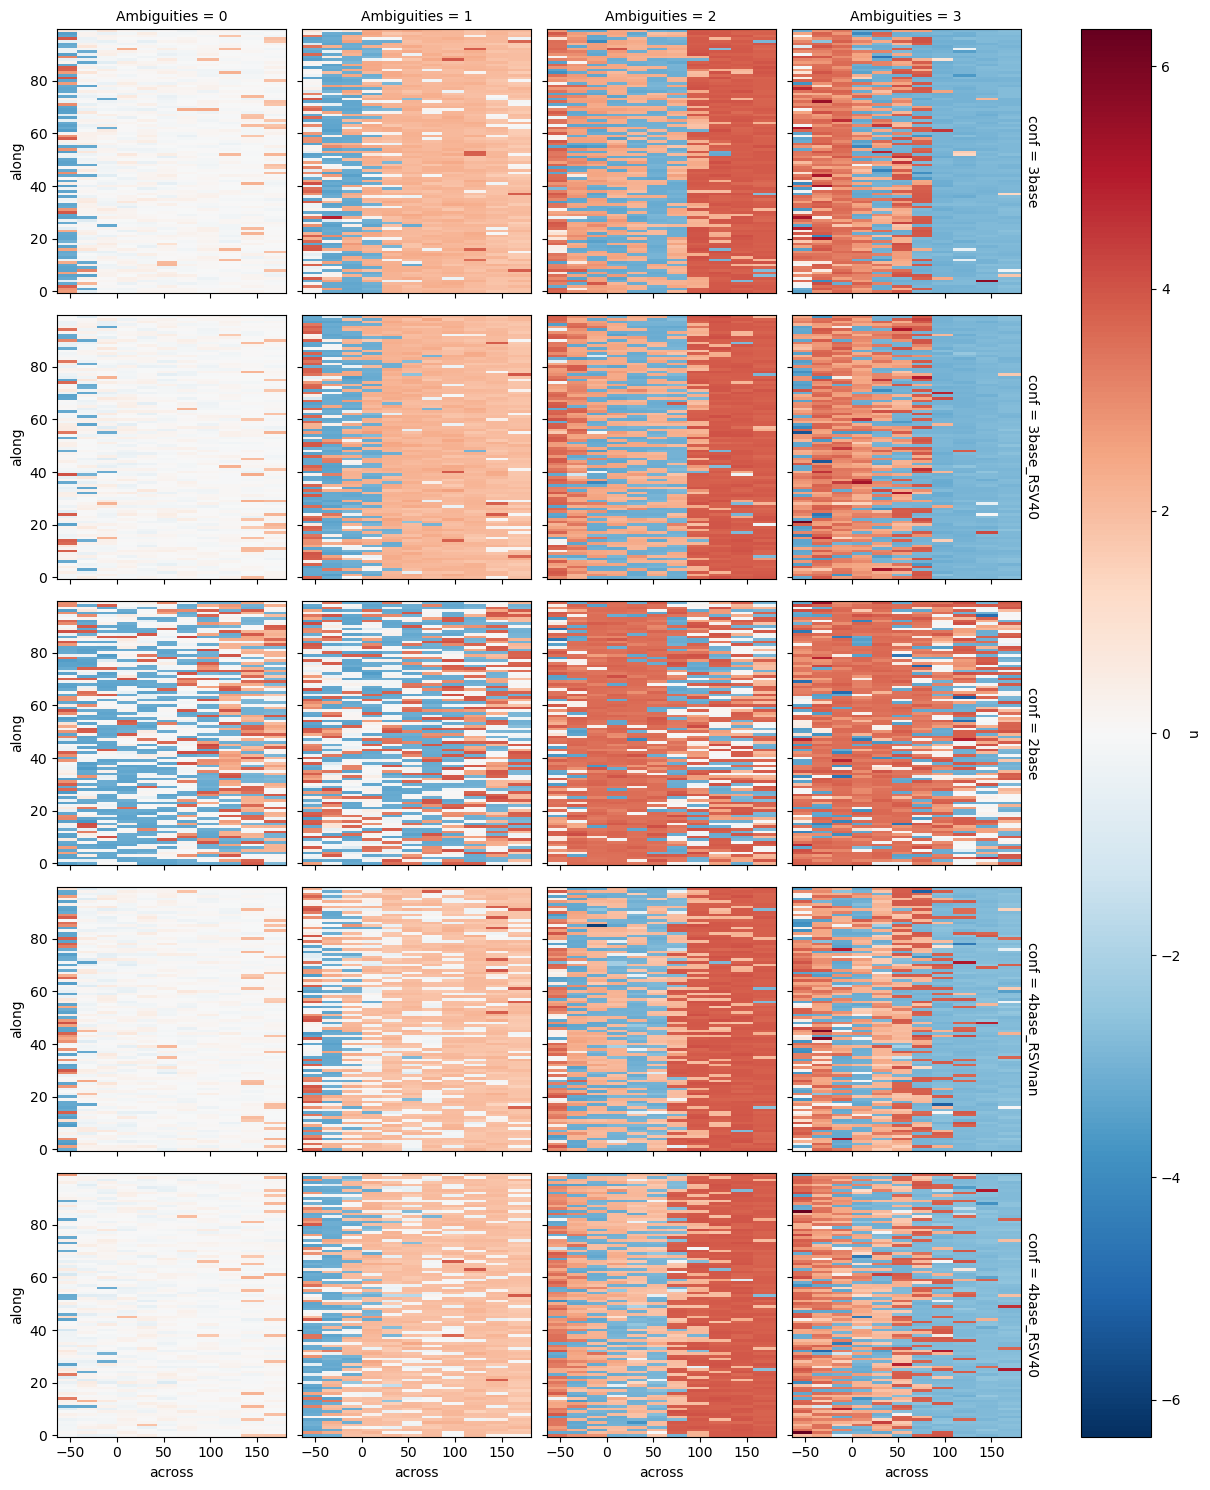

In [23]:
level2.u.sel(input_wdir=0).plot(x='across', y='along',col='Ambiguities',row='conf')

In [42]:
ambiguity_list = [
    {'name': 'sort_by_cost', 'method': 'sort_by_cost'},
    {'name': 'closest_truth', 'truth': truth, 'method': 'windcurrent'},
    {'name': 'closest_truth', 'truth': truth, 'method': 'wind'}, # => bug in concat below
    {'name': 'closest_truth', 'truth': truth, 'method': 'current'},
]
sol_list = [None] * len(ambiguity_list)
ambiguity_names = [None] * len(ambiguity_list)

for ii in range(len(sol_list)):
    sol_list[ii] = seastar.retrieval.ambiguity_removal.solve_ambiguity(level2, ambiguity_list[ii])
    ambiguity_names[ii] = ambiguity_list[ii]['method']
    sol_list[ii] = sol_list[ii].drop_vars('x_reduce', errors='ignore')

sol = xr.concat(sol_list, dim='ambiguity_names')
sol.coords['ambiguity_names'] = ambiguity_names

In [44]:
ambiguity_names

['sort_by_cost', 'windcurrent', 'wind', 'current']

In [45]:
level2b = seastar.retrieval.level2.sol2level2(sol)
level2b

<xarray.Dataset>
Dimensions:                     (across: 11, along: 100, x_variables: 4,
                                 Observables: 2, input_wdir: 24, conf: 5,
                                 ambiguity_names: 4)
Coordinates:
  * across                      (across) float64 -53.57 -32.14 ... 145.2 169.2
  * along                       (along) int64 0 1 2 3 4 5 ... 94 95 96 97 98 99
  * x_variables                 (x_variables) object 'u' 'v' 'c_u' 'c_v'
  * Observables                 (Observables) object 'sigma0' 'RSV'
    CentralFreq                 float64 1.35e+10
  * input_wdir                  (input_wdir) int32 0 15 30 45 ... 315 330 345
  * conf                        (conf) <U12 '3base' ... '4base_RSV40'
  * ambiguity_names             (ambiguity_names) <U12 'sort_by_cost' ... 'cu...
Data variables: (12/14)
    x                           (ambiguity_names, conf, input_wdir, across, along, x_variables) float64 ...
    cost                        (ambiguity_names, conf, input_wdir, across, along) float64 ...
    CurrentU                    (ambiguity_names, conf, input_wdir, across, along) float64 ...
    CurrentV                    (ambiguity_names, conf, input_wdir, across, along) float64 ...
    EarthRelativeWindU          (ambiguity_names, conf, input_wdir, across, along) float64 ...
    EarthRelativeWindV          (ambiguity_names, conf, input_wdir, across, along) float64 ...
    ...                          ...
    OceanSurfaceWindSpeed       (ambiguity_names, conf, input_wdir, across, along) float64 ...
    OceanSurfaceWindDirection   (ambiguity_names, conf, input_wdir, across, along) float64 ...
    EarthRelativeWindSpeed      (ambiguity_names, conf, input_wdir, across, along) float64 ...
    EarthRelativeWindDirection  (ambiguity_names, conf, input_wdir, across, along) float64 ...
    CurrentVelocity             (ambiguity_names, conf, input_wdir, across, along) float64 ...
    CurrentDirection            (ambiguity_names, conf, input_wdir, across, along) float64 ...
Attributes:
    inst:     ../instruments/inst_3base_3AC15_35_011x_SNKp03RSV07_MVNKp04RSVn...
    geo:      ../geo/geo_011x100_W005_000_C0.6_150.nc
    truth:    ../truths/truth_3base_3AC15_35_011x100_SNKp03RSV07_MVNKp04RSVna...
    level1:   ../level1s/level1_3base_3AC15_35_011x100_SNKp03RSV07_MVNKp04RSV...

In [52]:
err = level2b - truth
err['flag'] = level2b.cost > 4
rmse = np.sqrt((err.where(~err.flag)**2).mean(dim='along'))

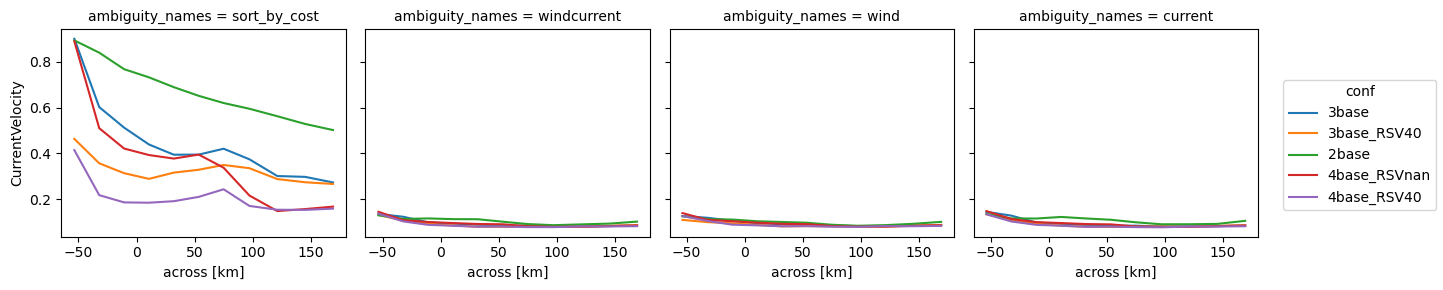

In [56]:
rmse.mean(dim='input_wdir').CurrentVelocity.plot(col='ambiguity_names', hue='conf', x='across')

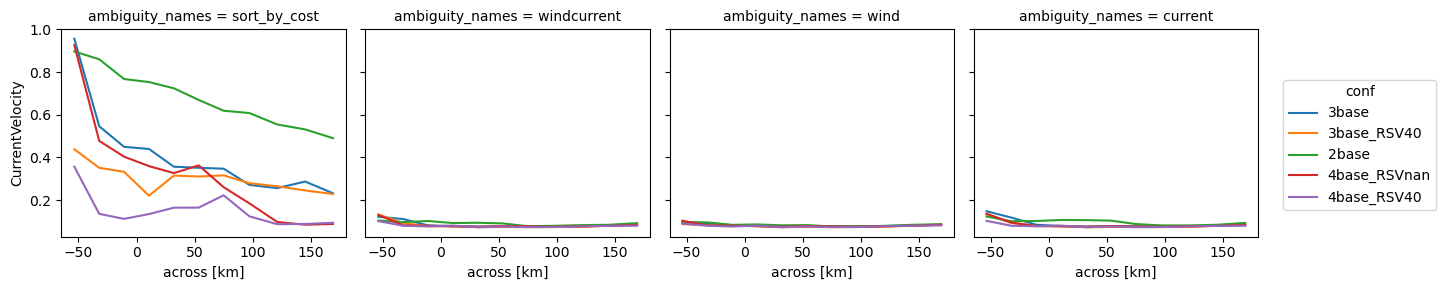

In [62]:
rmse.median(dim='input_wdir').CurrentVelocity.plot(col='ambiguity_names', hue='conf', x='across')

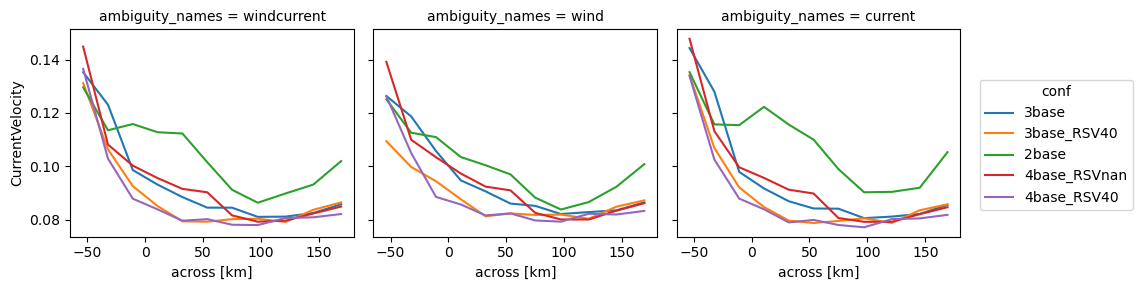

In [59]:
rmse.mean(dim='input_wdir').sel(ambiguity_names=['windcurrent','wind','current']).CurrentVelocity.plot(col='ambiguity_names',hue='conf', x='across')

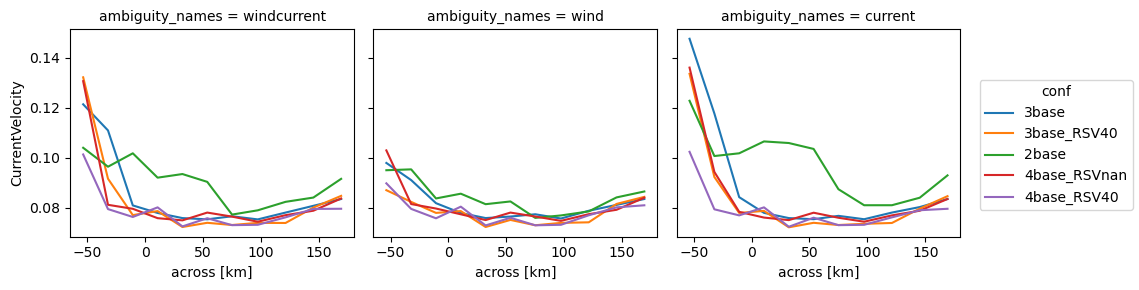

In [63]:
rmse.median(dim='input_wdir').sel(ambiguity_names=['windcurrent','wind','current']).CurrentVelocity.plot(col='ambiguity_names',hue='conf', x='across')

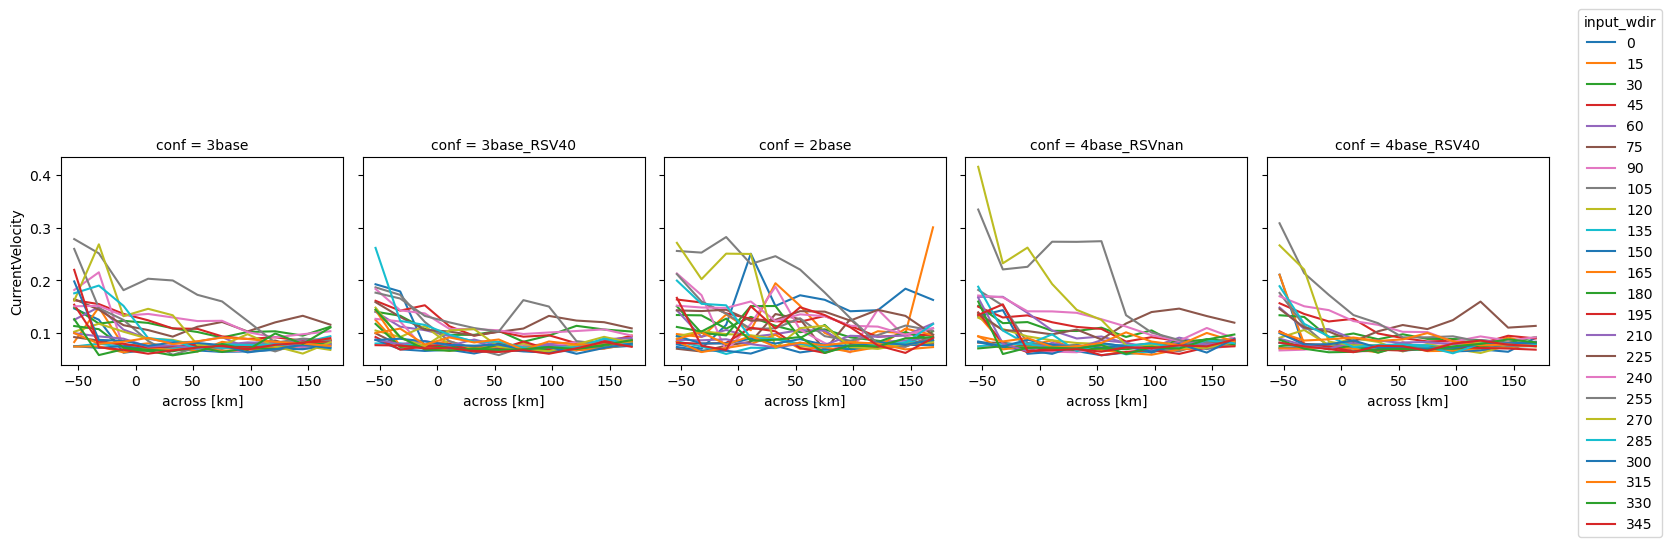

In [65]:
rmse.sel(ambiguity_names='current').CurrentVelocity.plot(col='conf',hue='input_wdir', x='across')

In [72]:
rmse

<xarray.Dataset>
Dimensions:                     (ambiguity_names: 4, conf: 5, input_wdir: 24,
                                 across: 11, x_variables: 4, Observables: 2)
Coordinates:
  * across                      (across) float64 -53.57 -32.14 ... 145.2 169.2
  * x_variables                 (x_variables) object 'u' 'v' 'c_u' 'c_v'
  * Observables                 (Observables) object 'sigma0' 'RSV'
    CentralFreq                 float64 1.35e+10
  * input_wdir                  (input_wdir) int32 0 15 30 45 ... 315 330 345
  * conf                        (conf) <U12 '3base' ... '4base_RSV40'
  * ambiguity_names             (ambiguity_names) <U12 'sort_by_cost' ... 'cu...
Data variables: (12/13)
    CurrentU                    (ambiguity_names, conf, input_wdir, across) float64 ...
    CurrentV                    (ambiguity_names, conf, input_wdir, across) float64 ...
    EarthRelativeWindU          (ambiguity_names, conf, input_wdir, across) float64 ...
    EarthRelativeWindV          (ambiguity_names, conf, input_wdir, across) float64 ...
    OceanSurfaceWindU           (ambiguity_names, conf, input_wdir, across) float64 ...
    OceanSurfaceWindV           (ambiguity_names, conf, input_wdir, across) float64 ...
    ...                          ...
    OceanSurfaceWindDirection   (ambiguity_names, conf, input_wdir, across) float64 ...
    EarthRelativeWindSpeed      (ambiguity_names, conf, input_wdir, across) float64 ...
    EarthRelativeWindDirection  (ambiguity_names, conf, input_wdir, across) float64 ...
    CurrentVelocity             (ambiguity_names, conf, input_wdir, across) float64 ...
    CurrentDirection            (ambiguity_names, conf, input_wdir, across) float64 ...
    flag                        (ambiguity_names, conf, input_wdir, across) float64 ...

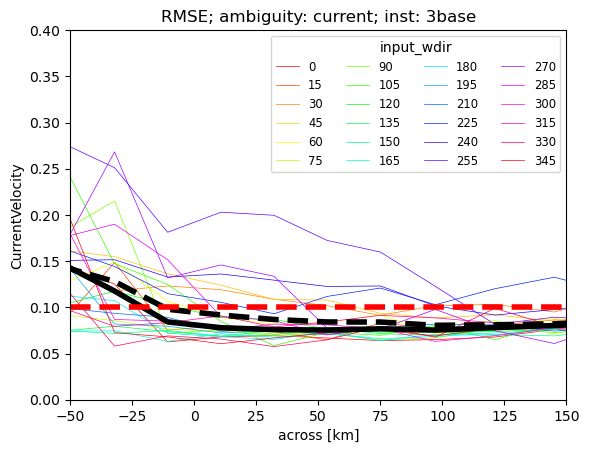

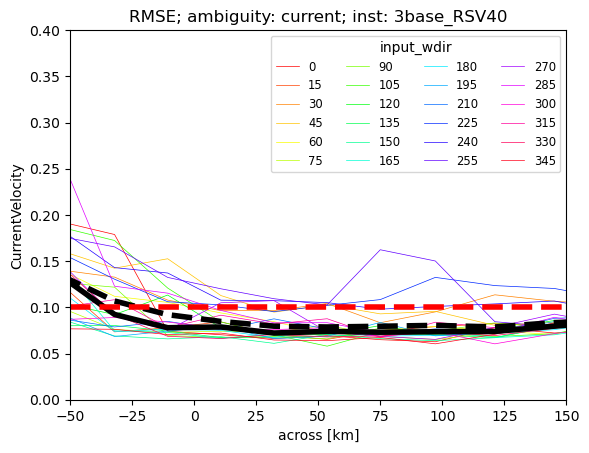

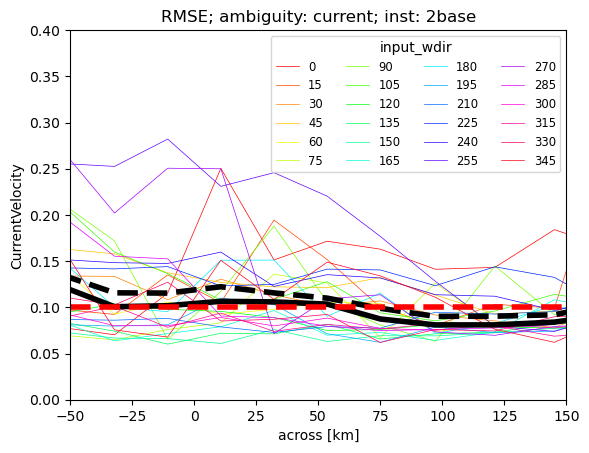

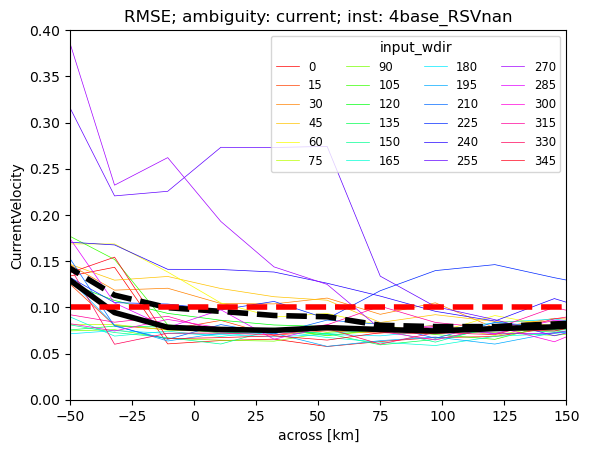

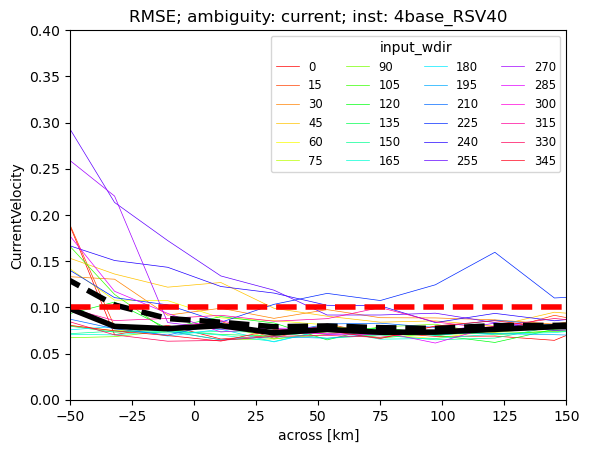

In [88]:
for cc, conf in enumerate(rmse.conf):

    fig, ax = plt.subplots()
    cmap = plt.cm.hsv(np.linspace(0,1,len(err.input_wdir)))
    ax.set_prop_cycle("color", cmap)
    g=rmse.CurrentVelocity\
            .sel(ambiguity_names='current')\
            .sel(conf=conf.values)\
            .plot(x='across', hue='input_wdir',
                 linewidth=colorlinewidth)# add_legend=True,)# add_colorbar=True)
    rmse.CurrentVelocity\
        .sel(ambiguity_names='current')\
        .sel(conf=conf.values)\
        .mean(dim='input_wdir').plot(ls='--', color='k', linewidth=4)
    rmse.CurrentVelocity\
        .sel(ambiguity_names='current')\
        .sel(conf=conf.values)\
        .median(dim='input_wdir').plot(ls='-', color='k', linewidth=4)
    plt.plot([-50, 160], [0.1, 0.1], 'r--', lw=4)
    plt.ylim([0,0.4])
    plt.xlim([-50,150])
    plt.title('RMSE; ambiguity: current' + '; inst: ' + conf.values[()])
    ax.legend(rmse.input_wdir.data, title='input_wdir', loc='upper right', ncol=4, fontsize='small')